### Detection of Covid-19 Using X-ray Image by Muhammad Saeed (MC180405742)

The goal of the proposed project called “Detection of Covid-19 Using X-Ray Images” is to develop an automatic detection system to detect covid-19.In this software, we intend to use the chest x-ray for the detection of coronavirus infected patients in an automated manner. This system will be helpful to hospital doctors for early identifying patients with high likelihood of Coronavirus.

### Importing all the prerequisite Libraries

In [3]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

### Defining some Parameters

In [4]:
#Resizing images to the same size 
IMAGE_SIZE = [224, 224] # 224 x 224 is the width and height 

# training configuration:
epochs = 500
batch_size = 32

#define paths
covid_path = r'D:\Final Year Project_Saeed\dataset\chest x_rays\Covid//'
normal_path = r'D:\Final Year Project_Saeed\dataset\chest x_rays\Normal//'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
normal_files = glob(normal_path + '/*')

### Fetching Images and Labelling class from Files

In [5]:
# Preparing Labels
covid_labels = []
normal_labels = []

covid_images=[]
normal_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Covid')
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('Normal')

### Visualizing First 30 Images from the Data set

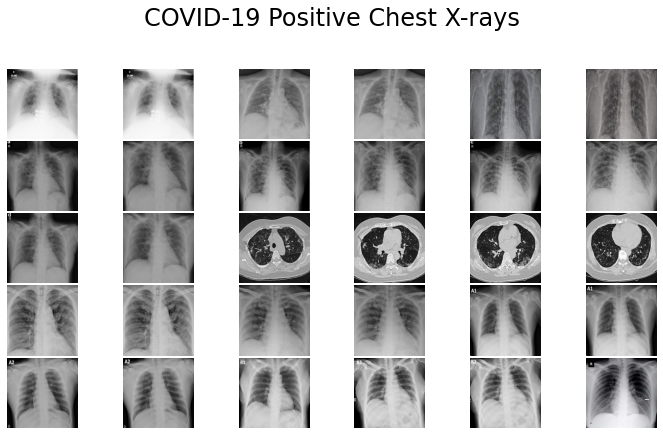

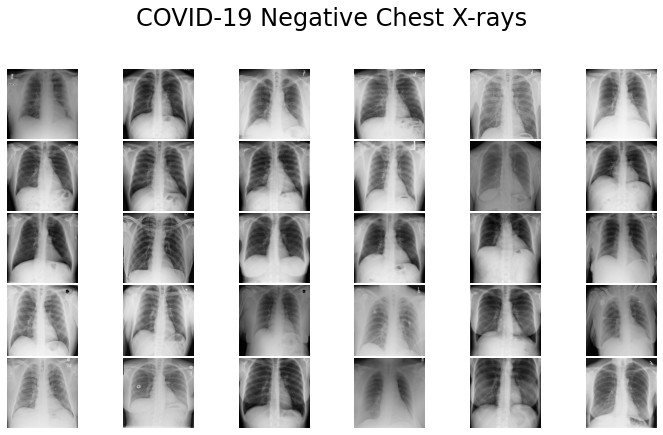

In [7]:
# look at random images
def plot_images(images, title):
    nrows, ncols = 5, 6
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'COVID-19 Positive Chest X-rays')
plot_images(normal_images, 'COVID-19 Negative Chest X-rays')

### **Preprocessing with Image Normalization**

 **Model takes images in the form of array of pixels. Hence convert into array and normalize**

In [9]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255

### **Dataset Splitting inTrain & Test**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# splitting into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

# making labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### **Visualizing some images from Training and Test sets**

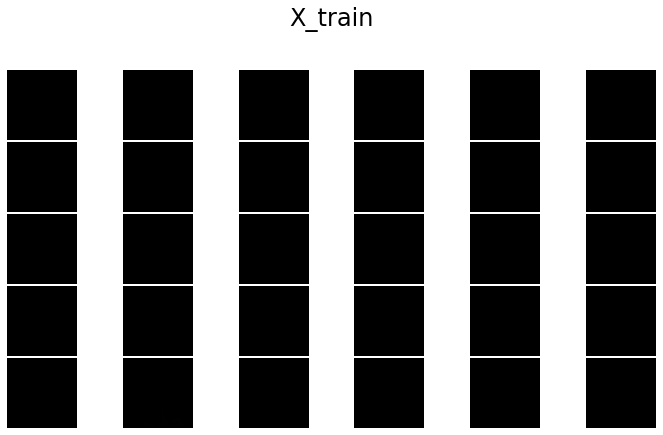

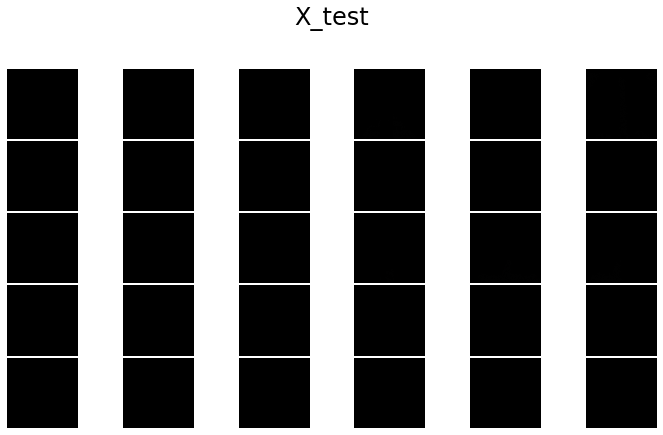

In [11]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building model (Using Pre trained CNN Model ResNet50)**

In [12]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Summarizing Model**

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### **Training CNN model on our own dataset**

In [17]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 7s 302ms/step - loss: 1.0197 - accuracy: 0.6051 - val_loss: 0.8021 - val_accuracy: 0.6117
Epoch 2/500
24/23 [==============================] - 7s 298ms/step - loss: 0.8803 - accuracy: 0.6503 - val_loss: 0.8184 - val_accuracy: 0.6277
Epoch 3/500
24/23 [==============================] - 7s 298ms/step - loss: 0.9541 - accuracy: 0.6383 - val_loss: 0.5332 - val_accuracy: 0.7447
Epoch 4/500
24/23 [==============================] - 7s 300ms/step - loss: 0.9481 - accuracy: 0.6303 - val_loss: 0.6110 - val_accuracy: 0.6968
Epoch 5/500
24/23 [==============================] - 7s 299ms/step - loss: 0.9143 - accuracy: 0.6529 - val_loss: 0.4753 - val_accuracy: 0.7819
Epoch 6/500
24/23 [==============================] - 7s 306ms/step - loss: 1.2179 - accuracy: 0.6051 - val_loss: 0.5150 - val_accuracy: 0.7872
Epoch 7/500
24/23 [==============================] - 7s 308ms/step - loss: 1.3787 - accuracy: 0.5904 - val_loss: 2.2570 - val_accuracy: 0.5957

### **Saving the trained model**

In [0]:
model.save(r'D:\Final Year Project_Saeed\models\resnet_chest.h5')

In [0]:
model.save_weights('resnetweights_chest.hdf5')

###  **Load an already saved model (If there is a trained model already saved on drive)**

In [14]:
model = load_model(r'D:\Final Year Project_Saeed\models\resnet_chest.h5')

### **Making Predicions**

In [15]:
y_pred = model.predict(X_test, batch_size=batch_size)

### **Displaying First 5 predictions**

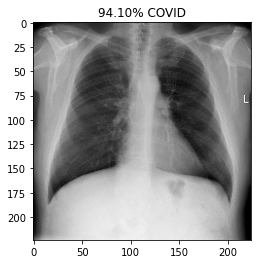

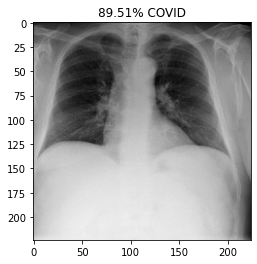

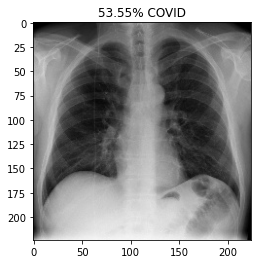

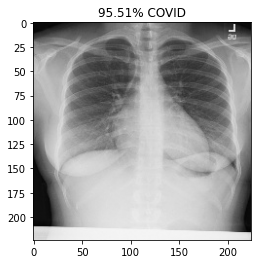

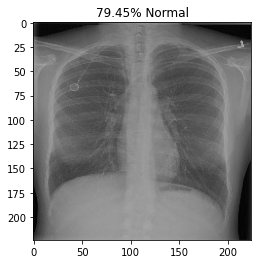

In [16]:
prediction=y_pred[0:5]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Normal')
  plt.imshow(X_test[index])
  plt.show()

In [17]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### **Plotting ROC Curve (receiver operating characteristic curve)**

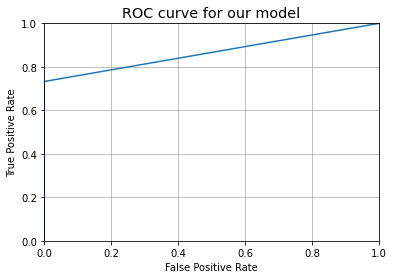

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### **Plotting Confusion Matrix**

Confusion Matrix without Normalization


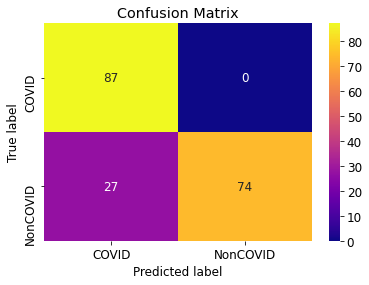

Confusion Matrix with Normalized Values


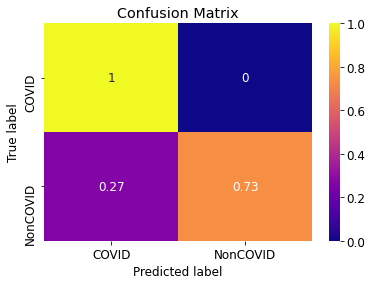

In [19]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report of Model**

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        87
           1       1.00      0.73      0.85       101

    accuracy                           0.86       188
   macro avg       0.88      0.87      0.86       188
weighted avg       0.89      0.86      0.85       188



### **Accuracy and Loss Plots**

In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


NameError: name 'history' is not defined

<Figure size 720x720 with 0 Axes>

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

NameError: name 'history' is not defined

<Figure size 720x720 with 0 Axes>